# Portfolio Optimization

## 1. Introduction

Portfolio optimization is a way to calculate the expected profit from a set of assets (which can be stock, credits, bonds, derivatives, calls, puts, etc). The goal of portfolio optimization is to minimize risk and maximize returns of a set of assets that is also called a portfolio. The process is not as easy as it seems. In 1952, Markowitz showed that risks and returns are usually linked, so high rewards are usually associated to high risks. <br>
In this notebook, I will try to give a glimpse of how the problem is treated classically and how to translate it to quantum computation.

In [1]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import *
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer 
from qiskit_optimization.applications import OptimizationApplication
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import stockdata as std

## 2. The optimization problem

We can build the optimization problem by defining a vector $x\in\{0,1\}^n$ that has each entry equal to an asset in the portfolio. We can build the problem defining a quadratic program with linear constraints. Then, <br><br>

<div align="center"> <font size=5em >$\min_{x \in \{0, 1\}^n}: $</font> <font size=5em >$q x^T\Sigma x$</font> - <font  size=5em>$\mu^T x$</font> </div>

<div align="center"> <font size=5em >$subject$</font> <font size=5em >$to: 1^T x = B$</font> </div>

- $Σ$ is a covariance matrix. The covariance matrix shows in each of its entry the correlation between the assets. Whenever the covariance is positive, then the assets rise or fall together, the opposite happens when the covariance is negative; 
- $q$ is called a risk factor (risk tolerance), that is the amout of risk an individual is willing to take and it usually ranges from 0 to 1;
- $\mu$ is the expected return and is something we want to maximize. It is calculated by taking the mean of value of the asset and multiplying by a weight, $w$. Notice that the weights for the assets sum to 1;
- $n$ is the number of assets in our portfolio;
- $B$ stands for Budget which is the number of assets we can allocate in our portfolio.

The final objective is to find which asset to acquire.

In [2]:
# Set parameters for assets and risk factor
num_assets = 4     # Number of assets
q = 0.5                   # Risk factor 
budget = 2           # Budget
weights = np.ones(num_assets)*(1/num_assets) #Weights for the mean mu
stock = ['VALE','PBR','PFE','HPE'] #Chosen stocks
days, stocks_data = std.Stocks_Array(num_assets, stock) #Stock data

In this notebook we will build the optimization to choose two stocks between four possibilities: Vale, Petrobras, Pfeizer, and HP. We can check bellow how each stock changed with time.

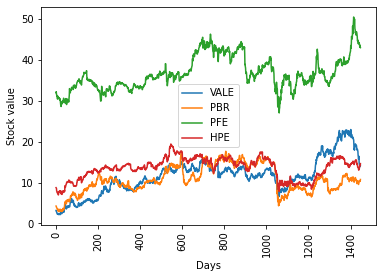

In [3]:
for i in range(num_assets):
    plt.plot(stocks_data[i], label=stock[i])
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Days')
plt.ylabel('Stock value')
plt.show()

In [4]:
#Get mu and sigma
mu, sigma = std.Get_Mu_Cov(stocks_data, num_assets, weights) 

We can also plot the covariance matrix to see how they relate to each other.

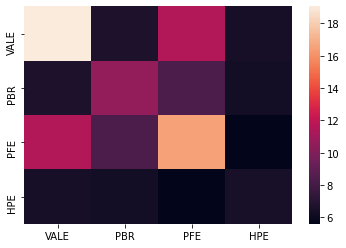

In [5]:
ax = sns.heatmap(sigma,xticklabels=stock, yticklabels=stock)

## 3. Solving the optimization problem with Qiskit
### Classical result

The problem of portofolio optimization can be easily solved in quiskit. The qiskit_finance module offer a function PortifolioOptimization that returns the quadratic program with the desired restriction. Qiskit also offers a way to classical solve the portfolio optimization problem and we will use it now.

In [6]:
#Building quadratic program
portfolio = PortfolioOptimization(expected_returns = mu, covariances = sigma, risk_factor = q, budget = budget)
qportfolio = portfolio.to_quadratic_program()

#Classical result
classical_es = NumPyMinimumEigensolver()
classical_solver= MinimumEigenOptimizer(classical_es)
result = classical_solver.solve(qportfolio)
print(result)

optimal function value: 4.550589298818258
optimal value: [0. 0. 1. 1.]
status: SUCCESS


### Quantum result with VQE

The Variational Quantum Eigensolver (VQE) is an algorithm that finds the smallest eigenvalue of a Hamiltonian $H$. In this hybrid algorithm, a quantum subroutine is executed inside a classical loop. The VQE can be defined as

- We first define an ansatz state $|{\psi(\theta)}\rangle$ with $\theta$ being predetermined parameters;

- Measure the expectation value $\langle\psi(\theta)|H|\psi(\theta)\rangle$;

- Use a non-linear classical optimizer to minimize the expectation value above by varying the parameters $\theta$;

- Iterate until convergence.<br><br>

Notice, however, that we do not have a Hamiltonian, but a quadratic program. To fix that we will define our cost funciont C(X) as <br><br>
<div align="center"> $C(x)=$ $q x^T\Sigma x$ - $\mu^T x$. </div>

We will map $x_i$ to an operator $\hat{x}_i = (I-z_i)/2$ such that<br><br>
<div align="center">$\hat{x}|x\rangle = x|x\rangle$</div>, 
    
where $x\in\{0,1\}$. After this map is done for all entries of $x$, we get a Hamiltonian $H_C$ where will get<br><br>
<div align="center">$H_C|x\rangle = C(x)|x\rangle$</div>.

We already know how to transform our quadratic program and we need to also transform the restraint to this Hamiltonian format. This is easily done by adding a term given by<br><br>
<div align="center">$A\bigg(\sum_{i}\hat{x}_i-B\bigg)^2$</div>. 
        
Notice that if we have more (or less) ones than the budget, a positive value is added to the Hamiltonian.

In [7]:
#Quantum result with VQE and qiskit
optimizer = SLSQP(maxiter=1000)
backend = Aer.get_backend('statevector_simulator')

vqe = VQE(quantum_instance=backend, optimizer = optimizer)
vqe_solver = MinimumEigenOptimizer(vqe)
result = vqe_solver.solve(qportfolio)
print(result)

optimal function value: 4.550589298818258
optimal value: [0. 0. 1. 1.]
status: SUCCESS


We can see that VQE gave us the same result of $|0011\rangle$ (or $|1100\rangle$ if you are more comfortable with the Qiskit notation) as the classical optimizer!

### Quantum result with QAOA

While VQE was interested in finding and optimize a quantum state to find the lowest eigenvalue of a Hamiltonian, the quantum approximate optimization algorithm (QAOA) works different. It is still a hybrid algorithm and it can be defined with the following steps:

- Define a cost Hamiltonian, $H_C$, where it encodes the optimization problem with its lowest eigenvalue being the solution;
- Define a mixer Hamiltonian, $H_x$;
- Construct the circuit $e^{-i\gamma H_c}$ and $e^{-i\alpha H_x}$ where the former is called the cost layer while the latter is the mixer layer;
- Choose $n$ pairs of layers, with $n\geq 1$, and build the circuit<br><br>
<div align="center">$U(\mathbf{\gamma},\mathbf{\alpha}) = e^{-i\alpha_1 H_x}e^{-i\gamma_1 H_c}\dots e^{-i\alpha_n H_x}e^{-i\gamma_n H_c}$</div><br><br>
- Build an inital state, and optimize the parameters $\gamma$ and $\alpha$ of $U(\mathbf{\gamma},\mathbf{\alpha})$ with a classical optmizer;
- After optimization, measure the expected value of the circuit and you get the solution of the problem!

The cost Hamiltonian was already built above, so we only need to define the mixer Hamiltonian as<br><br>
<div align="center">$H_x= X_1\otimes X_2\otimes\dots\otimes X_m$,</div><br><br>
where $X_i$ is the X Pauli matrix acting on qubit $i$ and $m$ is the total number of qubits.

In [8]:
#Quantum result with QAOA and qiskit
qaoa = QAOA(optimizer = optimizer, quantum_instance = backend, reps = 3)
qaoa_solver = MinimumEigenOptimizer(qaoa)
result = qaoa_solver.solve(qportfolio)
print(result)

optimal function value: 4.550589298818258
optimal value: [0. 0. 1. 1.]
status: SUCCESS


Notice, again, that we also get the correct result from the QAOA algorithm!

## 4. Solving the optimization problem with Pennylane
### Quantum result with QAOA

Pennylane does not have a function like Qiskit that solves the problem automatically by giving some inputs. Therefore, we will to build the circuit from scratch. 

The first step is to use the qaoa class from Pennylane to build a function, QAOA_Layer, that will create each layer of the circuit in the function Circuit. Then, with the cost Hamiltonian and mixer Hamiltonian, we can get the expected value of the cost Hamilonina and start optimizing our parameters, params.

In [9]:
import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as pnp
from matplotlib import pyplot as plt
import hamiltonian as ham

#Quantum result with QAOA and Pennylane
wires = np.arange(num_assets)
dev = qml.device("default.qubit", wires=num_assets)

def Qaoa_Layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

def Circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(Qaoa_Layer, depth, params[0], params[1])
    
@qml.qnode(dev)
def Cost_Function(params):
    Circuit(params)
    return qml.expval(cost_h)

@qml.qnode(dev)
def Probability_Circuit(gamma, alpha):
    Circuit([gamma, alpha])
    return qml.probs(wires=wires)

A module was created to build both Hamiltonians with penalty of $A=200$.

In [10]:
cost_h = ham.W_Cost_Hamiltonian(num_assets, mu, sigma, q, budget)
mixer_h = ham.Mix_Hamiltonian(num_assets)

Now, we are ready to run the QAOA with our functions and we obtain the correct result of $|0011\rangle$!

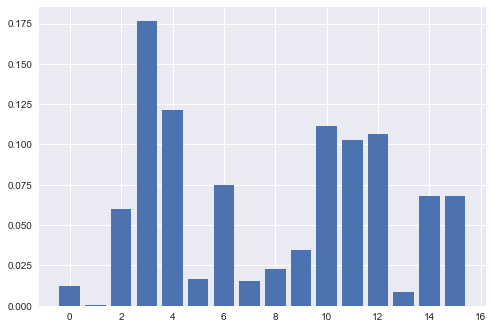

In [11]:
depth = 5

optimizer = qml.GradientDescentOptimizer()
steps = 1000
params = pnp.array(np.ones((2,depth))*0.5, requires_grad=True)

for i in range(steps):
    params = optimizer.step(Cost_Function, params)

probs = Probability_Circuit(params[0], params[1])

plt.style.use("seaborn")
plt.bar(np.arange(2 ** len(wires)), probs)
plt.show()

### Quantum result with VQE
As we saw before, VQE is all about optimizing the quantum state to find the smallest eigenvalue of a Hamiltonian. We will construct our ansatz state with the function Ansatz that uses Pauli X and CNOT in the circuit. Notice that the number of parameters are four times the number of assets. Then, the function VQE will get the expected value of our cost Hamiltonian. 

In [12]:
#Quantum result with VQE and Pennylane
def Ansatz(params, num_assets = num_assets):
    for i in range(num_assets):
        qml.RX(params[i], wires=i)
    for i in range(num_assets):
        for j in range(i,num_assets):
            if i != j:
                qml.CNOT(wires=[i,j])
    for i in range(num_assets,2*num_assets):
        qml.RX(params[i], wires=i%num_assets)
    for i in range(num_assets):
        for j in range(i,num_assets):
            if i != j:
                qml.CNOT(wires=[i,j])
    for i in range(2*num_assets,3*num_assets):
        qml.RX(params[i], wires=i%num_assets)
        
@qml.qnode(dev)
def VQE(params):
    Ansatz(params)
    return qml.expval(cost_h)

@qml.qnode(dev)
def Prob_Circuit(params):
    Ansatz(params)
    return qml.probs(wires=wires)

Now, we can throw all that into our classical optimizer and find the optimal values of our parameters. When we measure the probabilties of our basis in the state built with those optimal parameters, we will get the correct result of $|0011\rangle$!

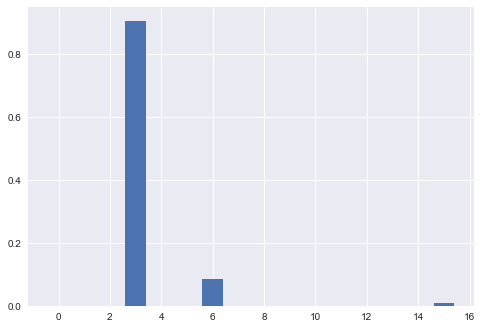

In [13]:
params = pnp.array(np.ones(num_assets*4)*0.5, requires_grad=True)
steps = 1000
for i in range(steps):
    params = optimizer.step(VQE, params)

    

plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)),Prob_Circuit(params))
plt.show()